[<img src="https://www.arcosdorados.com/wp-content/uploads/2019/05/ArcosDoradosLogoX.png" width="300" height="150" align='right'>](http://digitalhouse.com.ar/)

### Introducción:

La descripcion de cada columna es la siguiente:


marketplace       - Codigo de País donde se escribió la reseña

customer_id       - Identificador unico de los autores de las reseñas, que sirve para agruparlos.

review_id         - Identificador Unico para la reseña

product_id        - Identificador unico del producto reseñado

product_parent    - Identificados aleatorio, utilziado para agregar reseñas de un producto.

product_title     - Descripción del producto

product_category  - Categoría: Luggage (Equipajes) 

star_rating       - Rating de 1 a 5 estrellas

helpful_votes     - Número de votos favorable que ha tenido cada reseña (otros clientes consideran que la reseña es útil)

total_votes       - Número total de votos de la reseña, inlcuyendo los faorables y no favorables.

vine              - “Y” indica que la reseña hace parte de un programa de reseñas patrocinadas, donde los autores 
reciben el producto de manera gratuita para escribir la reseña

verified_purchase – La reseña fue escrita por un autor cuya compra del ítem fue verificada

review_headline   - Titular de la Reseña

review_body       - Texto completo de la Reseña.

review_date       - Fecha en que la reseña fue escrita.

Al carecer de información descarto:

marketplace
review_id
review_date
product_id
product_category
product_parent

solo conservo un subset de variables que tienen algun valor para las preguntas de negocios planteadas.


In [1]:
# Importo las librerias que voy a utilizar.
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('wordnet')

/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package wordnet to /home/elias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Columnas seleccionadas.
selected_columns = ['customer_id', 'star_rating','product_id','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body']

In [ ]:
# Importo el dataset provisto relacinado con compras en amazon.
df = pd.read_csv('amazon_reviews_us_Luggage_v1_00.tsv',sep='\t',error_bad_lines=False,usecols=selected_columns)

In [ ]:
# shape del dataset.
df.shape

In [ ]:
# Tipos de las columnas.
df.dtypes

In [ ]:
# Genero una serie de la distribucion de estrellas.
barData = df.star_rating.value_counts(normalize=True)*100

In [ ]:
barData


In [ ]:
# Hago el grafico de barras por estrella.
plt.Figure()
sns.barplot(x=[ int(i) for i in barData.index],y=barData);
plt.xlabel('Stars', fontsize=16)
plt.ylabel('% percentage', fontsize=16)
plt.savefig('images/stars_dist.png')

In [ ]:
# Frecuencia acumumulada de estrellas.
barData[barData.index < 3].sum(),barData[barData.index > 3].sum()

**Conclusiones:** Tengo sobre representado mucha gente con 3-5 estrellas (79 %) y del 12 % restante tiene muy malas reseñas.

## Clasificador y sentiment analysis.
### Clasificador con variable objetivo como número de estrellas.

La idea es generar un clasificador de reseñas que devuelva la puntuacion de la misma en funcion del texto.

In [ ]:
# Funcion para lemmatizar.
def lemmaSentence(sentence):
    import nltk
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    punctuations="?:!.,;"
    sentence_words = nltk.word_tokenize(sentence)
    txt_procesado =''
    for word in sentence_words:
        txt_procesado += (str(wordnet_lemmatizer.lemmatize(word, pos="v"))) + ' '
    return txt_procesado

In [ ]:

# Saco todas las reseñas vacias y genero un dataset donde tengo el body de cada una de ellas.
df_txt = df.dropna(subset=['review_body'])
# sentiment positive and negative.
df_txt['sentiment'] = df_txt.star_rating.apply(lambda x: 0 if x<3 else 1)
# generate column from body plus title.
df_txt['review_title_body']=df_txt.apply(lambda x: str(x['review_body']) + ' ' +str(x['review_headline']),axis=1)
# Lemmatizo las palabras.

# lemmatize body
df_txt['review_body_lemm']=df_txt['review_body'].apply(lambda x: lemmaSentence(x))
# lemmatize body and title.
df_txt['review_body_title_lemm']=df_txt['review_title_body'].apply(lambda x: lemmaSentence(x))

In [ ]:
# Genero las dummies
dumm = pd.get_dummies(df_txt[['vine','verified_purchase']],drop_first=True)
# Agrego las dummies al dataset.
df_txt = pd.concat([df_txt,dumm],axis=1)

In [ ]:
# Guardo el datraFrame para luego poder utilizarlo mas rapidamente.
df_txt.to_csv('amazon_reviews_us_Luggage_v1_00_preproc.csv',index=False)

In [2]:
# Cargo el modelo con variables preprocesadas-
df_final = pd.read_csv('amazon_reviews_us_Luggage_v1_00_preproc.csv')

In [3]:
# Defino mi stopwords
my_words = ['br','bag','one', 'two' ,'three', 'four' ,'five' ,'stars']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

In [4]:
# Genero una funcion que devuelve una modelo logistico.
def train_model(X_train, X_test, y_train, y_test,le,cm_fig=None):
    '''Entrena un modelo bayesiano multinomial'''
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    from sklearn.model_selection import RandomizedSearchCV
    import numpy as np
    # Instanciate model.
    logistic = LogisticRegression()
    
    # Create regularization penalty space
    penalty = ['l1']

    # Create regularization hyperparameter distribution using uniform distribution
    C = np.logspace(-3,5,20)
    #C = [1]

    # Create hyperparameter options
    hyperparameters = dict(C=C, penalty=penalty)

    # Create randomized search 5-fold cross validation and 100 iterations
    clf = RandomizedSearchCV(logistic, hyperparameters, random_state=1, cv=5, verbose=0, n_jobs=-1,scoring='f1_macro')

    # Fit randomized search
    clf.fit(X_train, y_train)

    # save best Model.
    best_model = clf.best_estimator_
    # print best params
    print(clf.best_params_)
    # hago la prediccion.
    labels_predichas = best_model.predict(X_test)
    # Calculo el accuracy del mismo.
    print(accuracy_score(y_test, labels_predichas))
    cm = confusion_matrix(y_test, labels_predichas)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax=sns.heatmap(cmn.T, square=True, annot=True, fmt='.2f', cbar=False,
            xticklabels=list(set(le.classes_)), yticklabels=list(set(le.classes_)))
    plt.xlabel('True')
    plt.ylabel('Predicted')
    if cm_fig is not None:
        plt.savefig(cm_fig)
    else:
        pass
    cr = classification_report(y_test, labels_predichas)
    return cr


In [5]:
X = df_final['review_body']
le = LabelEncoder()
y=le.fit_transform(df_final['star_rating'])
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(278761,) (69691,) (278761,) (69691,)


In [7]:
list(le.classes_)

[1.0, 2.0, 3.0, 4.0, 5.0]

In [8]:
#Primera aproximacion con countVectorizer
# Pongo stopWords en ingles.
modelo_cvec = CountVectorizer(ngram_range = ((1,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.99)
# Fiteo sobre el X_train
X_train = modelo_cvec.fit_transform(X_train)
# Transformo sobre el test.
X_test = modelo_cvec.transform(X_test)
# 57251 palabras distintas. matrix muy sparsa.
print(X_train.shape,X_test.shape)

(278761, 386) (69691, 386)


/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'penalty': 'l1', 'C': 14384.4988828766}
0.6708326756683073
CPU times: user 8.42 s, sys: 365 ms, total: 8.78 s
Wall time: 4min 39s


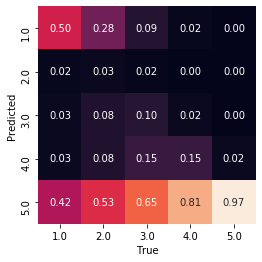

In [9]:
%time results_countv= train_model(X_train, X_test, y_train, y_test,le,'images/cm_5_stars.png')

In [10]:
print(results_countv)

              precision    recall  f1-score   support

           0       0.57      0.50      0.53      4999
           1       0.30      0.03      0.05      3571
           2       0.37      0.10      0.16      5567
           3       0.44      0.15      0.22     12278
           4       0.70      0.97      0.81     43276

    accuracy                           0.67     69691
   macro avg       0.48      0.35      0.36     69691
weighted avg       0.60      0.67      0.60     69691



# Positivo o negativo

In [11]:
df_final['sentiment_class'] = df_final['star_rating'].apply(lambda x: 'Negative' if x<3 else 'Positive')

In [12]:
df_final.sentiment_class.value_counts(normalize=True)

Positive    0.87703
Negative    0.12297
Name: sentiment_class, dtype: float64

In [13]:
X = df_final['review_body']
le = LabelEncoder()
y=le.fit_transform(df_final['sentiment_class'])
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)
from sklearn.feature_extraction.text import CountVectorizer
modelo_sentiment = CountVectorizer(ngram_range = ((1,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.99)
# Entreno con el count directamente.
X_train = modelo_sentiment.fit_transform(X_train)
# transformo sobre el test.
X_test = modelo_sentiment.transform(X_test)
# Imprimo directamente el shape de ambos.
print(X_train.shape,X_test.shape)

(278761, 386) (69691, 386)


/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'penalty': 'l1', 'C': 5455.594781168515}
0.9139630655321347


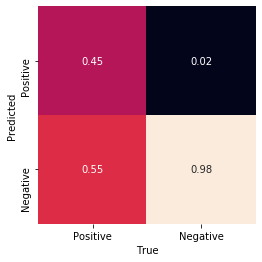

In [14]:
results_sentiment = train_model(X_train, X_test, y_train, y_test,le,'images/cm_sentiment.png')

In [15]:
print(results_sentiment)

              precision    recall  f1-score   support

           0       0.75      0.45      0.56      8570
           1       0.93      0.98      0.95     61121

    accuracy                           0.91     69691
   macro avg       0.84      0.71      0.76     69691
weighted avg       0.91      0.91      0.90     69691



### Prediccion
Entreno el modelo que voy a disponibilizar.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
X = df_final['review_body']
le = LabelEncoder()
y=le.fit_transform(df_final['sentiment_class'])
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)
from sklearn.feature_extraction.text import CountVectorizer
modelo_sentiment = CountVectorizer(ngram_range = ((1,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.99)
# Imprimo directamente el shape de ambos.
logistic_r = LogisticRegression(penalty='l1',C=5455)


In [17]:
from sklearn.pipeline import Pipeline, make_pipeline
text_clf = make_pipeline(modelo_sentiment, logistic_r)
text_clf.fit(X_train, y_train)

/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.99,
                                 max_features=None, min_df=0.01,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'al...
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=5455, class_weight=None, dual=False,
     

In [26]:
coef_array = pd.Series({var: coef for var,coef in zip(modelo_sentiment.vocabulary_.keys(),text_clf.named_steps['logisticregression'].coef_[0])}).sort_values()


In [27]:
coef_array[coef_array==0]

Series([], dtype: float64)

In [29]:
pd.DataFrame(coef_array.head(10).sort_values(),columns=['coeficiente'])

,coeficiente
high quality,-1.802881
book,-1.682564
really like,-1.632879
outside,-1.466545
ipad,-1.365731
price,-1.307423
extremely,-1.112567
clothing,-1.046114
easily,-0.904515
liked,-0.867206


In [30]:
pd.DataFrame(coef_array.tail(10).sort_values(ascending=False),columns=['coeficiente'])

,coeficiente
holding,2.200663
end,2.195808
leather,1.874649
problems,1.820847
home,1.819798
went,1.696544
absolutely,1.695443
worth,1.678070
smell,1.667484
laptop,1.661071


In [ ]:
# scoreo la base completa

In [43]:
df_final['proba']=df_final.review_body.apply(lambda x: text_clf.predict_proba([x])[0][1])

In [69]:
diez_negativas = df_final.sort_values(by='proba')[['review_body','sentiment','proba','helpful_votes']].head(10).reset_index(drop=True)
diez_positivas = df_final.sort_values(by='proba',ascending=False)[['review_body','sentiment','proba','helpful_votes']].head(10).reset_index(drop=True)

In [70]:
diez_negativas

,review_body,sentiment,proba,helpful_votes
0,I'm very disappointed in these bags. I bought ...,0,1.419903e-09,1.0
1,"First, up front disclaimer: I didn't buy this ...",0,1.396350e-08,0.0
2,I will not try these again. Stay away of this ...,0,4.078801e-08,0.0
3,I was told that it is standard procedure in al...,0,4.659581e-08,35.0
4,We ordered this set for a trip we're taking in...,0,1.680097e-07,8.0
5,Update: This bag's extending handle broke a li...,0,2.087649e-07,7.0
6,Read the description CAREFULLY before buying t...,0,3.165036e-07,2.0
7,I purchased this umbrella late Feb 2013 thinki...,0,3.785215e-07,1.0
8,Let me just start by asking: can I give this p...,0,3.919368e-07,2.0
9,"I am giving this item only 3 stars, not based ...",0,4.050683e-07,0.0


In [71]:
diez_positivas

,review_body,sentiment,proba,helpful_votes
0,BUG makes this same model bag in 4 colors; a l...,1,1.0,5.0
1,I wanted to wait until I used this before I wr...,1,1.0,14.0
2,These bottles/toobs work great for getting at ...,1,1.0,81.0
3,This is a review for a 4 pcs value set packing...,1,1.0,0.0
4,"I am very impressed with this bag, but before ...",1,1.0,91.0
5,These bottles/toobs work great for getting at ...,1,1.0,11.0
6,4.5 stars... This is a very good backpack. It'...,1,1.0,5.0
7,This listing is for the Black color. I have th...,1,1.0,3.0
8,"I have this in Brown, which is exactly like th...",1,1.0,1.0
9,I love love love my new backpack.<br /><br />I...,1,1.0,8.0


In [93]:
diez_positivas.review_body.iloc[4].replace('\\','').replace('<br />','').replace('"','')

"I am very impressed with this bag, but before I get to my own feedback, I want to address some issues that other reviewers have posted.1. The zippers do not slide down.The reviewer said,the side zippers like to slide down a lot. No they don't. The zippers work fine on this and haven't slid down once. In fact, with the exception of the one zipper directly next to the body, the only zippers which actually go up and down are the ones that make it expandable, so even if they did slide down it's not a loss. It's not like it's leaving anything open. The one next to the body doesn't move and likely wouldn't anyway since it sits next to you.2. The bag is not painful to use, if used properly.The reviewer said, This bag cuts across the neck when worn over the shoulder. Sure, if you have it set too tight or loose. That's like saying a belt is too tight or not tight enough. When you adjust it properly, it works fine. That said, if you're wearing a tank top or anything that isn't covered it will r

In [252]:
import numpy as np
nrow = np.random.choice(df_final[df_final.sentiment==0].index)
txt = df_final.loc[nrow,'review_body']
true_tag = df_final.loc[nrow,'sentiment_class']
txt2predict = modelo_sentiment.transform([txt])

In [59]:
txt ="I will not try these again. Stay away of this brand and save your money. They tore apart and became loose from the first international flight. These four pieces of luggage are poorly made, very cheap quality. Why am I giving this luggage a two star evaluation if I don't like them and if they are cheap? Because the smallest bag is the only piece that lived so far; I've using it to gather my important documents such as passports and the like. I also was able to use one of these pieces of luggage to store my stuff. The rest of the pieces unfortunately were ripped off and cannot hold anymore; the handles broke, the zippers malfunctioned. All in all, I discarded the three pieces and kept only the smaller one. Quality issues have been always my priority concerns of the products I buy; but I have to compromise when I cannot afford expensive things. When I purchased these pieces of luggage, I thought that they can hold up for at least several international flights, which I will accept based on the price of this product. I have come up to a conclusion that I am truly wasting my money on purchasing cheap luggage and will not do it again. This is the third time that I purchase cheap luggage and this product is much more worse than the other one. While they are both were made of cheap quality, the other company (I am afraid that I cannot name it) was much better; I am still using two pieces of these.   Anyhow, I would add little (or much) more money on something that I ca really make use of instead of scattering my money on unworthy products. If you are thinking to purchase these pieces of luggage for an international flight, think again; you are really wasting your money."


In [60]:
text_clf.predict_proba([txt])

array([[9.99999959e-01, 4.07880114e-08]])

In [61]:
le.classes_[text_clf.predict([txt])[0]]

'Negative'

In [64]:
from eli5.lime import TextExplainer
te = TextExplainer(random_state=42)
te.fit(txt, text_clf.predict_proba)
results = te.show_prediction(target_names=list(set(le.classes_)))
results

### Persistencia del modelo.

In [ ]:
import pickle

In [166]:
with open('predictor.pkl', 'wb') as handle:
    pickle.dump((text_clf,le), handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
# probar el servidor

In [65]:
txt

"I will not try these again. Stay away of this brand and save your money. They tore apart and became loose from the first international flight. These four pieces of luggage are poorly made, very cheap quality. Why am I giving this luggage a two star evaluation if I don't like them and if they are cheap? Because the smallest bag is the only piece that lived so far; I've using it to gather my important documents such as passports and the like. I also was able to use one of these pieces of luggage to store my stuff. The rest of the pieces unfortunately were ripped off and cannot hold anymore; the handles broke, the zippers malfunctioned. All in all, I discarded the three pieces and kept only the smaller one. Quality issues have been always my priority concerns of the products I buy; but I have to compromise when I cannot afford expensive things. When I purchased these pieces of luggage, I thought that they can hold up for at least several international flights, which I will accept based o

In [66]:
import requests
#WS_URL = 'http://biodatasciencearg.pythonanywhere.com/sentiment/'
WS_URL = 'http://127.0.0.1:5000/sentiment/'
data={"data":txt}
r = requests.post(WS_URL, json=data)
print(r)
content = r.json()

<Response [200]>


In [67]:
content

{'label': 'Negative',
 'proba': '100.000',
 'results': '     <style>     table.eli5-weights tr:hover {         filter: brightness(85%);     } </style>                                                                                                                                       <p style="margin-bottom: 0.5em; margin-top: 0em">             <b>              y=Positive      </b>           (probability <b>1.000</b>, score <b>-15.943</b>)  top features         </p>          <table class="eli5-weights"            style="border-collapse: collapse; border: none; margin-top: 0em; table-layout: auto; margin-bottom: 2em;">         <thead>         <tr style="border: none;">                              <th style="padding: 0 1em 0 0.5em; text-align: right; border: none;" title="Feature contribution already accounts for the feature value (for linear models, contribution = weight * feature value), and the sum of feature contributions is equal to the score or, for some classifiers, to the probab

In [68]:
import IPython
IPython.core.display.HTML(content['results'])



## WordClouds 

In [94]:
textos_positivos = df_final[df_final.sentiment==1].review_body
textos_negativos = df_final[df_final.sentiment==0].review_body

### textos positivos. 

In [95]:
vectorizer = CountVectorizer(ngram_range = ((2,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.98)
tdm = vectorizer.fit_transform(textos_positivos)
freqs_pos = {word: tdm.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}


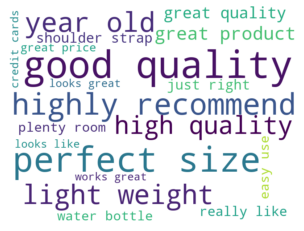

In [96]:
w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=2000)
w.generate_from_frequencies(freqs_pos)
plt.imshow(w, interpolation='bilinear')
plt.axis("off")
plt.show()

### textos Negativos

In [97]:
vectorizer = CountVectorizer(ngram_range = ((2,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.98)
tdm = vectorizer.fit_transform(textos_negativos)
freqs_neg = {word: tdm.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}


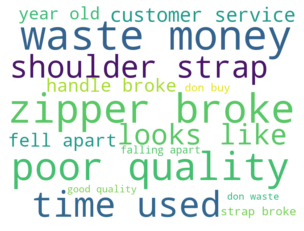

In [98]:
w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=2000)
w.generate_from_frequencies(freqs_neg)
plt.imshow(w, interpolation='bilinear')
plt.axis("off")
plt.show()

Propuesta para maximizar: La idea es acciones que aumenten las ventas. Por lo tanto tendria que ver algo que efectivamente 
    en el clustering diferencie los grupos que tienen muchas reseñas con votos utiles de aquellas que no. Tal vez en el texto vea algo que efectivamente me permita generar buenas reseñas.